In [1]:
from __future__ import division
import hoomd
import hoomd.md
import hoomd.dem

In [2]:
hoomd.context.initialize("")

HOOMD-blue 2.3.0 DOUBLE HPMC_MIXED SSE SSE2 SSE3 
Compiled: 04/25/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using DEM. Please cite the following:
* M Spellings, R L Marson, J A Anderson, and S C Glotzer. "GPU accelerated
  Discrete Element Method (DEM) molecular dynamics for conservative, faceted
  particle simulations",  Journal of Computational Physics 334 (2017) 460--467
-----
HOOMD-blue is running on the CPU


In [3]:
#Places the squares on a square lattice.
#HOOMD will apply rotational equations of motion (uses degrees of freedom that have 
#non-zero moments of inertia)
#Gives every particle a moment of inertia around the z-axis

uc = hoomd.lattice.unitcell(N=1,
                           a1 = [4,0,0],
                           a2 = [0,4,0],
                           a3 = [0,0,1],
                           dimensions = 2,
                           position = [[0,0,0]],
                           type_name = ['A'],
                           mass = [1.0],
                           moment_inertia = [[0,
                                             0,
                                             1/12]],
                           orientation = [[1,0,0,0]])

In [4]:
import numpy
snapshot = uc.get_snapshot()
snapshot.replicate(5,5,1)
snapshot.particles.velocity[:,0:2] = numpy.random.normal(0.0, numpy.sqrt(1.6/1.0),
                                                        [snapshot.particles.N, 2])

In [5]:
hoomd.init.read_snapshot(snapshot)

notice(2): Group "all" created containing 25 particles


In [6]:
n1 = hoomd.md.nlist.cell()

In [7]:
#DEM component applies pair potentials between particles that results in 
#both forces and torques on the particles
#Choose side length 2 (?)
#The WCA potential is applied between the edges, vertices, and faces with sigma = 2*r
#which rounds the square with radius 'r'.

squares = hoomd.dem.pair.WCA(radius=.1, nlist=n1)
square_verts = [[1,1], [-1,1], [-1,-1], [1,-1]]
squares.setParams('A', vertices=square_verts)

In [8]:
hoomd.md.integrate.mode_standard(dt=0.001)

In [9]:
#Using Newtonian equations of motion

all = hoomd.group.all()
hoomd.md.integrate.nve(group=all)

In [10]:
hoomd.analyze.log(filename="log-output7.log",
                 quantities=['potential_energy',
                            'translational_kinetic_energy',
                            'rotational_kinetic_energy'],
                 period=10,
                 overwrite=True)

In [11]:
hoomd.dump.gsd("trajectory7.gsd",
              period=100,
              group=hoomd.group.all(),
              overwrite=True)

In [12]:
hoomd.run(20*100)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 25
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:00 | Step 2000 / 2000 | TPS 61387.4 | ETA 00:00:00
Average TPS: 56650.8
---------
-- Neighborlist stats:
25 normal updates / 20 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 4 / n_neigh_avg: 1.04
shortest rebuild period: 43
-- Cell list stats:
Dimension: 5, 5, 1
n_min    : 0 / n_max: 3 / n_avg: 1
** run complete **


In [13]:
import numpy
from matplotlib import pyplot
%matplotlib inline

data = numpy.genfromtxt(fname='log-output7.log', skip_header=True)

Text(0,0.5,'potential_energy')

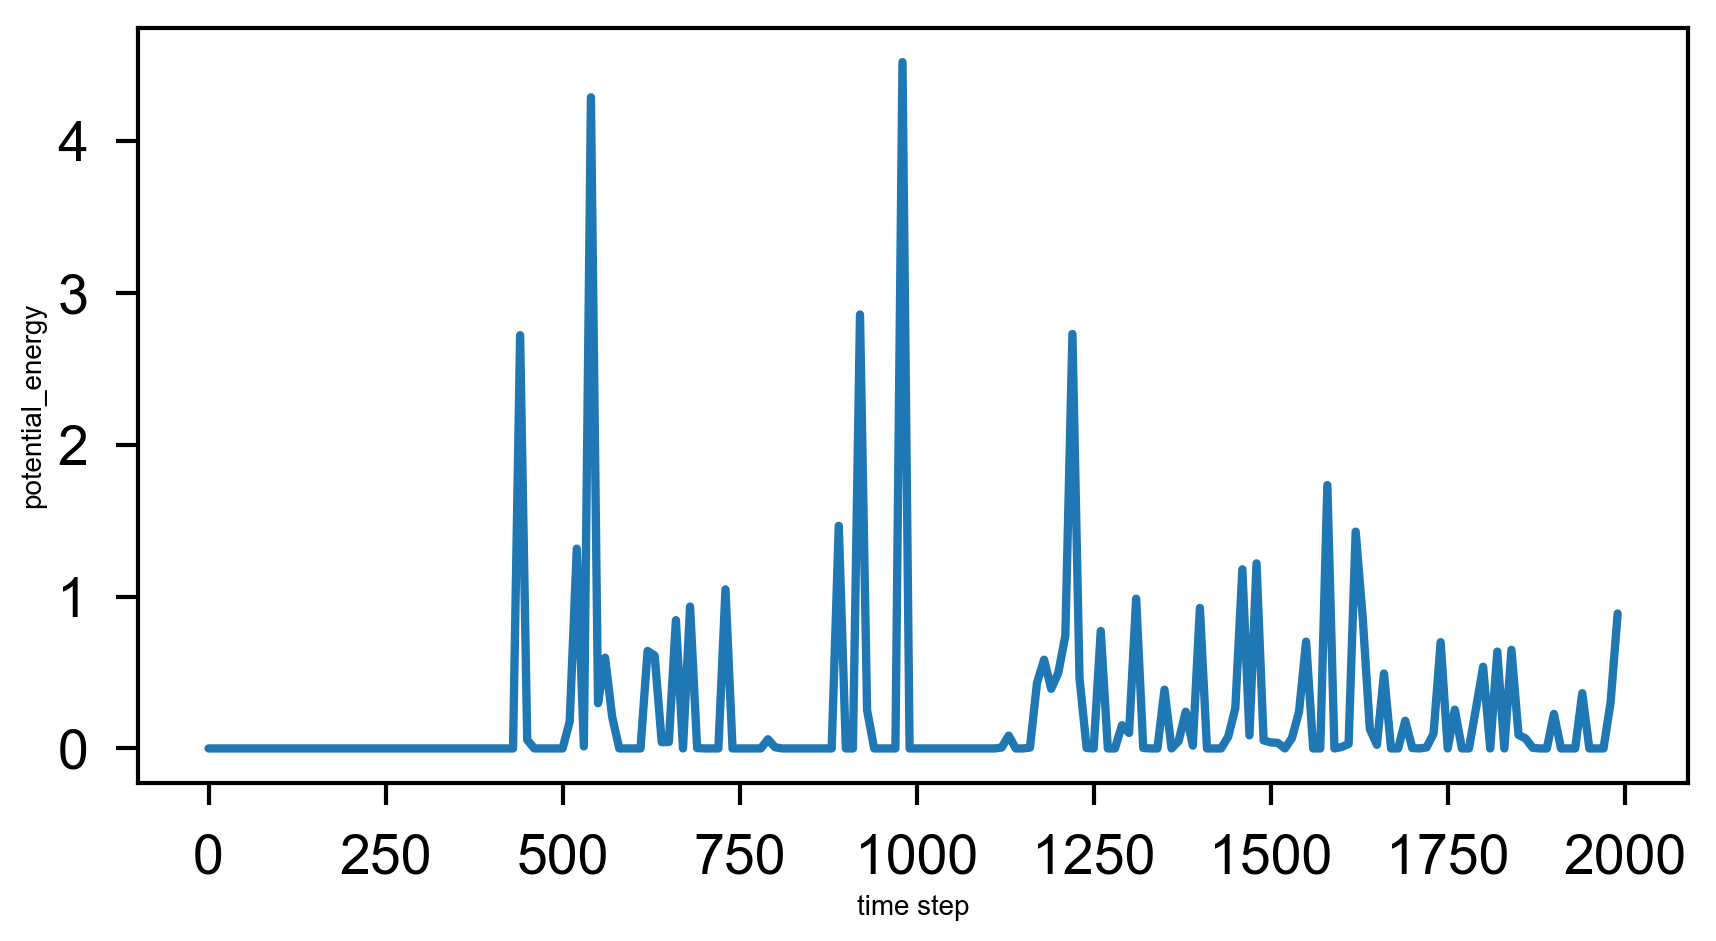

In [42]:
pyplot.figure(figsize=(10,5), dpi=200)
pyplot.plot(data[:,0], data[:,1])
pyplot.xlabel('time step')
pyplot.ylabel('potential_energy')

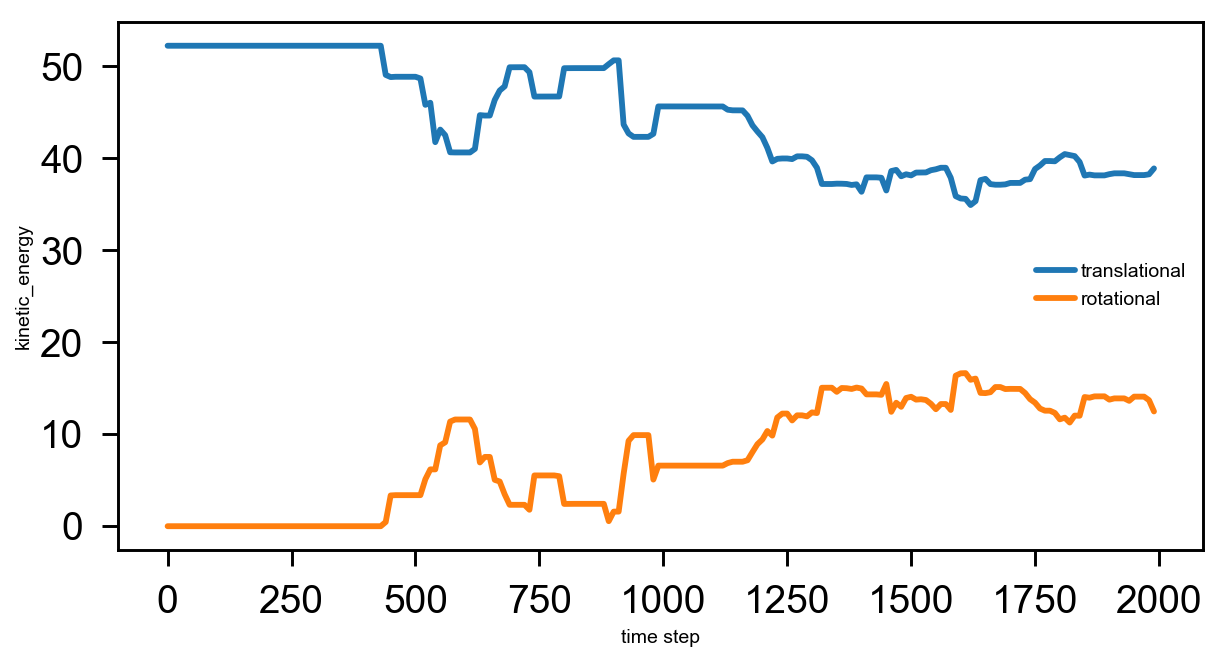

In [43]:
pyplot.figure(figsize=(10,5), dpi=140)
pyplot.plot(data[:,0], data[:,2])
pyplot.plot(data[:,0], data[:,3])
pyplot.xlabel('time step')
pyplot.ylabel('kinetic_energy')
pyplot.legend(['translational', 'rotational'], loc='center right')

Interesting that mispelling translational screwed up lots of things